In [36]:
from os.path import join as pathjoin
from data_processing import *
from interpretation import *
from models import *
from training import *

In [2]:
DATA_DIR = '/home/mlepekhin/data'
MODELS_DIR = '/home/mlepekhin/models'
MODEL_ID = 'allennlp_bert_base_cased'
CHECKPOINTS_DIR = pathjoin(MODELS_DIR, MODEL_ID, 'checkpoints')
BEST_MODEL = pathjoin(CHECKPOINTS_DIR, 'best.th')

In [3]:
transformer_model = 'bert-base-cased'
MAX_TOKENS = 512

### Loading of the pretrained model

In [4]:
vocab = Vocabulary().from_files(pathjoin(MODELS_DIR, MODEL_ID, 'vocab'))
model = build_transformer_model(vocab, transformer_model)

Building the model


In [5]:
id_to_label = vocab.get_index_to_token_vocabulary('labels')
print(id_to_label)
print(id_to_label.values())

{0: 'A1', 1: 'A12', 2: 'A7', 3: 'A16', 4: 'A8', 5: 'A22', 6: 'A4', 7: 'A11', 8: 'A14', 9: 'A9', 10: 'A17'}
dict_values(['A1', 'A12', 'A7', 'A16', 'A8', 'A22', 'A4', 'A11', 'A14', 'A9', 'A17'])


In [6]:
if torch.cuda.is_available():
    cuda_device = 0
else:
    cuda_device = -1
print(cuda_device)
model.load_state_dict(torch.load(BEST_MODEL, map_location=f'cuda:{cuda_device}'))

0


<All keys matched successfully>

### Data loading

In [7]:
en_test_df = pd.read_csv(pathjoin(DATA_DIR, 'en_test'))
en_test_df.head()

,Unnamed: 0,target,text
0,64,A4,THE PURLOINED LETTER . -----------------------...
1,1575,A7,Judge Finds Probable Cause Against a Greeley p...
2,1254,A11,"Sitting at the bar or in a booth like we did ,..."
3,790,A14,"Keywords : Crystallography , Thermal diffuse Z..."
4,1389,A12,What kind of professional business people can ...


In [8]:
true_classes = en_test_df.target.values
sentences = en_test_df.text.values

### Preliminary analysis

In [19]:
dataset_reader = build_transformer_dataset_reader(transformer_model, MAX_TOKENS)
predictor = TextClassifierPredictor(model, dataset_reader=dataset_reader)
predicted_classes = np.array(predict_classes(sentences, predictor, vocab))

In [29]:
print(type(predicted_classes == 'A1'))

<class 'numpy.ndarray'>


In [21]:
print(len(np.unique(true_classes)))

11


In [38]:
calc_classifier_metrics(predicted_classes, true_classes)

label (argum) f1_score 0.6404494382022472 precision 0.7402597402597403 recall 0.5643564356435643
label (fictive) f1_score 0.9090909090909091 precision 0.8928571428571429 recall 0.9259259259259259
label (instruct) f1_score 0.6428571428571429 precision 0.54 recall 0.7941176470588235
label (reporting) f1_score 0.746268656716418 precision 0.6756756756756757 recall 0.8333333333333334
label (legal) f1_score 0.8000000000000002 precision 0.7058823529411765 recall 0.9230769230769231
label (personal) f1_score 0.6190476190476191 precision 0.6842105263157895 recall 0.5652173913043478
label (commercial) f1_score 0.7183098591549295 precision 0.7727272727272727 recall 0.6710526315789473
label (research) f1_score 0.6 precision 0.5217391304347826 recall 0.7058823529411765
label (info) f1_score 0.6590909090909091 precision 0.7631578947368421 recall 0.58
label (eval) f1_score 0.8095238095238095 precision 0.7727272727272727 recall 0.85
label (stuff) f1_score 0.7894736842105263 precision 0.6666666666666666

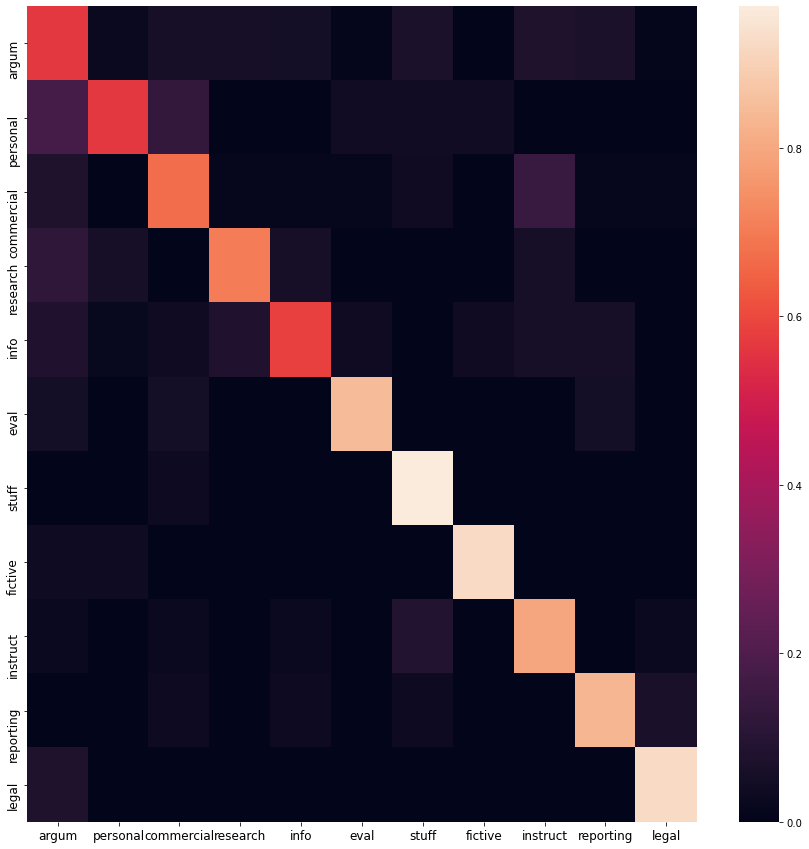

In [39]:
plot_confusion_matrix(predicted_classes, true_classes)

### Saliency Gradient Interpretation

In [40]:
smooth_grad = SmoothGradient(predictor)
simple_grad = SimpleGradient(predictor)
integrated_grad = IntegratedGradient(predictor)

In [41]:
mistake_ids = []

for sent_id in range(len(true_classes)):
    if true_classes[sent_id] != predicted_classes[sent_id]:
        mistake_ids.append(sent_id)

In [42]:
interpret_sentence(
    sentences[mistake_ids[0]], dataset_reader.tokenizer, 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[0]]],
    label_description[predicted_classes[mistake_ids[0]]]
)

TRUE LABEL: instruct
LABEL: argum
<class 'allennlp.interpret.saliency_interpreters.smooth_gradient.SmoothGradient'> TEXT:
Judge Find ##s Pro ##ba ##ble Cause Against a G ##ree ##ley police Officer A judge has found probable cause to have a trial in the sexual assault trial of a police officer charged with g ##rop ##ing a female driver he had stopped . The story in the Tribune also said the officer changed his story about not stopping the driver at all , when GPS records for his vehicle placed him at the site of the incident . This is just some of the procedures that the state and attorney for the defense go through in our criminal justice system . If you have been arrested for an assault , sexual or otherwise you can hire an expert to defend you . You can get a Colorado criminal defense attorney . In the case cited , the defendant ' s attorney filed a motion to dismiss the charges due to no probable cause . As happens , the aspects of a simple sexual assault case such as this sometimes

In [43]:
interpret_sentence(
    sentences[mistake_ids[1]], dataset_reader.tokenizer, 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[1]]],
    label_description[predicted_classes[mistake_ids[1]]]
)

TRUE LABEL: research
LABEL: info
<class 'allennlp.interpret.saliency_interpreters.smooth_gradient.SmoothGradient'> TEXT:
Key ##words : Crystal ##log ##raphy , The ##rmal di ##ff ##use Z ##in ##c ##ble ##nde structure , Diamond structure , Solid state physics , X - ray scattering , I ##ii - v compounds , Silicon , La ##tti ##ce dynamics , T ##ds , I ##i - v ##i compounds , I - v ##ii compounds . Classification : 7 . 8 , 8 . Nature of problem : Det ##er ##mination of single - p ##hon ##on di ##ff ##use X - ray scattering in lines , areas or volumes of re ##ci ##p ##ro ##cal space at any temperature , using e ##ige ##nda ##ta given by a lattice dynamic ##al model . Evaluation of contribution to one - p ##hon ##ons ##cat ##tering from ion ##ic def ##orm ##ations , modelled by a shell model . Sol ##ution method : The elements of the anal ##ytic solution are assembled from a combination of input data , ta ##bula ##ted scattering factors and transformation of a minimum set of e ##ige ##nda ##

In [44]:
interpret_sentence(
    sentences[mistake_ids[2]], dataset_reader.tokenizer, 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[2]]],
    label_description[predicted_classes[mistake_ids[2]]]
)

TRUE LABEL: commercial
LABEL: argum
<class 'allennlp.interpret.saliency_interpreters.smooth_gradient.SmoothGradient'> TEXT:
What kind of professional business people can benefit from using a 24 - hour message service ? Is it only for Doctor ' s and Den ##tist ' s Office ##s ? Would other profession ##s benefit from having a live reception ##ist answer their phone 24 hours a day , 7 days a week ? Let ' s take a look at that . The Office is a different place , these days . It ' s no longer a big building , with cu ##bby holes , and small partition ##s . An office nowadays is anywhere you set up your computer , or hold your cell phone . A lot of business people have now moved their offices into their own homes . Most people do n ' t have room for a reception ##ist in their bedroom , or kitchen , and would n ' t be able to afford the full - time salary anyway . But , there are a lot of reasons an answering service would be a work ##able solution for fields other than medical and dental . A